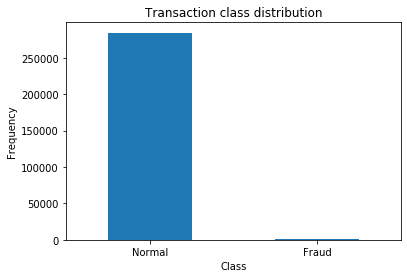

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# constants
LABELS = ["Normal", "Fraud"]
RANDOM_SEED = 105
split_size = 0.3
DATASET_NAME = "creditcard.csv"

# data reading
df = pd.read_csv(DATASET_NAME)
# describe dataset by classes
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [4]:
### data preparing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# преобразуем данные, убираем колонку "время", т.к. она ни на что не влияет
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# отделяем X от Y
Y = data['Class'].values
X = data.drop(['Class'], axis=1).values

# делим данные
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=split_size, random_state=RANDOM_SEED, shuffle=True)

X_test, X_comparison, Y_test, Y_comparison = train_test_split(
    X_test, Y_test, test_size=split_size, random_state=RANDOM_SEED, shuffle=True)

# количество мошенничеств в тестовых данных
sum(Y_test)

95

In [5]:
### Random Forest

# Creating model
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)

import joblib
file_name = 'RF-model.pkl'

In [8]:
# train model
RF_model.fit(X_train, Y_train)

# saving model
with open(file_name, 'wb') as f:
    joblib.dump(RF_model, f, compress=1)

In [6]:
# loading model
with open(file_name, 'rb') as f:
    RF_model = joblib.load(file_name)

In [7]:
predictions = RF_model.predict(X_test)

from sklearn.metrics import classification_report

report = classification_report(Y_test, predictions, target_names=LABELS)
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     59715
       Fraud       0.91      0.81      0.86        95

    accuracy                           1.00     59810
   macro avg       0.95      0.91      0.93     59810
weighted avg       1.00      1.00      1.00     59810



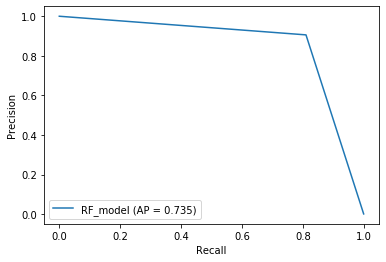

In [8]:
### Precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# calculations
precision, recall, _ = precision_recall_curve(Y_test, predictions)
average_precision = average_precision_score(Y_test, predictions)

# visualization
name = "RF_model"
plt.plot(recall, precision, label = f"{name} (AP = "f"{average_precision:0.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')

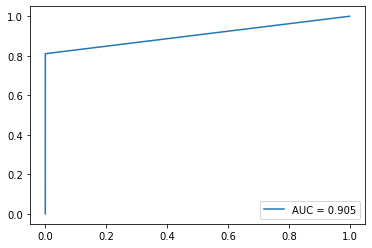

In [9]:
### ROC_AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.3f'% roc_auc)
plt.legend(loc= "lower right")
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, predictions)

0.905196173050058

In [10]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(RF_model, 
                        param_dist, 
                        n_iter = 50, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, Y_train)
rs.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 63.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 191.6min finished


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 13,
 'bootstrap': False}

In [22]:
# saving RandomizedSearch object
file_name = 'RF-rs'
with open(file_name, 'wb') as f:
    joblib.dump(rs, f, compress=1)

In [13]:
# loading RandomizedSearch object
file_name = 'RF-rs'
with open(file_name, 'rb') as f:
    rs = joblib.load(file_name)

In [14]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,12,2,sqrt,13,False,0.999544,1
1,400,23,2,sqrt,14,False,0.999518,2
2,600,23,2,sqrt,15,False,0.999503,3
3,600,50,2,sqrt,7,False,0.999458,4
4,500,39,18,sqrt,11,False,0.999443,5
5,700,23,12,sqrt,8,True,0.999438,6
6,300,28,7,log2,13,True,0.999433,7
7,400,23,12,sqrt,11,True,0.999433,7
8,1000,44,2,sqrt,9,True,0.999398,9
9,700,7,23,log2,12,False,0.999353,10


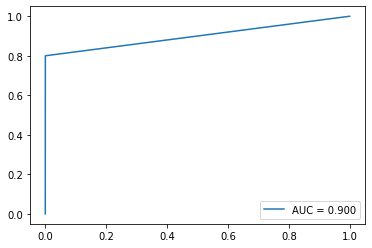

In [15]:
### ROU_AUC

improved_RF_model = rs.best_estimator_

predictions = improved_RF_model.predict(X_test)

fpr, tpr, _ = roc_curve(Y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.3f'% roc_auc)
plt.legend(loc= "lower right")
plt.show()

In [16]:
roc_auc_score(Y_test, predictions)

0.8999246420497363

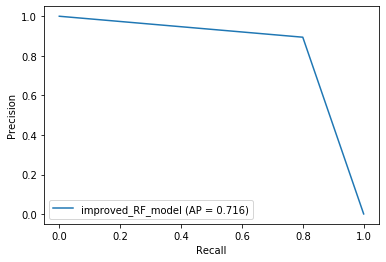

In [18]:
### ROC_PR

# calculations
precision, recall, _ = precision_recall_curve(Y_test, predictions)
average_precision = average_precision_score(Y_test, predictions)

# visualization
name = "improved_RF_model"
plt.plot(recall, precision, label = f"{name} (AP = "f"{average_precision:0.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='lower left')

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [600,400,700]
max_features = ['sqrt']
max_depth = [13, 14, 15]
min_samples_split = [12, 23, 50]
min_samples_leaf = [2, 18, 12]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rs.best_estimator_, param_grid, cv = 1, verbose = 1, n_jobs=-1)
gs.fit(X_train, Y_train)
gs.best_params_

In [ ]:
predictions = gs.predict(X_test)
print(roc_auc_score(Y_test, predictions))
print(average_precision_score(Y_test, predictions))